This is a program designed to plot the results of the spectrum analyser measuring the transmission of the microwaves through the waveguide. 

The other function this program perform a line fitting to the transmission power of the microwaves which is then used to generate a list (.txt file) which will hopefully result in a microwave list sweep that provides a constant power across the whole of the microwave frequency range. 

In [124]:
import numpy as np 
import pandas as pd 
import scipy.optimize as opt
import matplotlib.pyplot as plot 

In [125]:
def get_trace_data(folder_path, file_ID):
    # load the data from the trace file into a pandas data_frame.
    file_path = folder_path + file_ID
    data_frame = pd.read_csv(file_path, skiprows=17, names = ['Frequency (MHz)', 'Power (dBm)'])
    return(data_frame)

In [126]:
def plot_trace(data_frame):
    # plot the pandas dataframe as a sccatter graph
    fig, ax = plot.subplots()
    ax.scatter(data_frame['Frequency (MHz)'], data_frame['Power (dBm)'],
               label='transmitted power', marker = 'x')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Transmitted Microwave \n Power (dBm)')
    ax.legend()
    return(fig, ax)

In [127]:
def polynomial_4_curve(x, a, b, c, d,e):
    # a function to create a cubic line_shape
    y = a*np.power(x,4) + b*np.power(x, 3) + c*np.power(x, 2) + d*np.power(x,1) + e
    return(y)

In [128]:
def cubic_curve_fitting(data_frame):
    # use the data frame to generate a cubic fit for the data. 
    x = data_frame['Frequency (MHz)']
    y = data_frame['Power (dBm)']
    P0 = [-1, 1, -1, 1, 1] # initial fitting parameters
    
    coeffs, confidence = opt.curve_fit(polynomial_4_curve, x, y, P0)
    errors = np.sqrt(np.diag(confidence))
    
    return(coeffs, errors)

In [137]:
def create_corrected_power_arrray(freq, power_array, desired_power_array):
    # A method to create a list for the microwave generator that should
    # correct for the losses in the waveguide. 
    power_difference = desired_power_array - power_array
    power_correction =  np.round(power_difference,2)
    
    return(power_correction)

In [144]:
def save_list(frequency_array, power_correction):
    destination_folder = 'C:\\Users\\Ryan\\Desktop\\'
    output_data_file = destination_folder + date + '_Microwave_power_list_15dBm.txt'
    
    with open(output_data_file, "w") as wf:
        for i in range(len(frequency_array)-1):
            wf.write(str(int(frequency_array[i])) + '\t' + str(power_correction[i]) + '\n') 
    

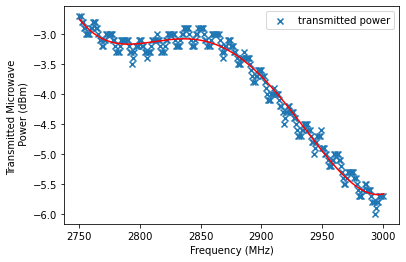

In [146]:
# Get the folder location for the trace files. The trace name and 
# the load the data into a pandas data_frame. 

folder_path  = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\20200908\\'
date = '20200908'
file_ID = 'TRACE001.csv'

transmission_data = get_trace_data(folder_path, file_ID)
fig, ax = plot_trace(transmission_data)

fitted_cubic_coeffs, fitted_cubic_errors = cubic_curve_fitting(transmission_data)

start_freq = transmission_data['Frequency (MHz)'][0]
stop_freq = transmission_data['Frequency (MHz)'][len(transmission_data['Frequency (MHz)'])-1]+1
step_size = 1
number_of_steps = int((stop_freq - start_freq)/step_size)

frequency_array = np.linspace(start_freq, stop_freq, number_of_steps+1)
y = polynomial_4_curve(frequency_array, fitted_cubic_coeffs[0], fitted_cubic_coeffs[1],
               fitted_cubic_coeffs[2], fitted_cubic_coeffs[3], fitted_cubic_coeffs[4])

plot.plot(frequency_array, y, color = 'r')

fixed_power_array = np.full((len(frequency_array)), y[0])

power_correction = create_corrected_power_arrray(frequency_array, y, fixed_power_array)

save_list(frequency_array*1000000, power_correction+15)